## Lectura de los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
%matplotlib inline

/home/abarsotti/Programming/VirtualEnv/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PICTURE_SIZE = 64
CHANNELS = 'RGB'
INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend([f'{color}{i}' for i in range(PICTURE_SIZE ** 2)])

In [3]:
def show_images(samples, title='path'):
    for index, sample in samples.iterrows():
        if title is not None:
            if isinstance(title, str):
                title = [title, ]
            title_text = ', '.join(str(sample[title_field]) for title_field in title)
            plt.title(title_text)

        sample_as_grid = sample[INPUT_COLUMNS].values.reshape(len(CHANNELS), PICTURE_SIZE, PICTURE_SIZE).astype(np.float)
        sample_as_grid = np.transpose(sample_as_grid) / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

In [4]:
training = pd.read_csv('data/training.tar.xz', compression='xz')
training.rename(columns={'training.csv': 'R0'}, inplace=True)

test_validation = pd.read_csv('data/validation.tar.xz', compression='xz')
test_validation.rename(columns={'validation.csv': 'R0'}, inplace=True)

In [20]:
test, validation = train_test_split(test_validation, test_size=0.5, random_state=47)

## Etiquetas posibles

In [36]:
print(f'Existen {len(training.label.unique())} etiquetas posibles en el dataset utilizado:')
for label in training.label.unique():
    print(f'  - {label}')

Existen 64 etiquetas posibles en el dataset utilizado:
  - Apple Braeburn
  - Apple Golden 1
  - Apple Golden 2
  - Apple Golden 3
  - Apple Granny Smith
  - Apple Red 1
  - Apple Red 2
  - Apple Red 3
  - Apple Red Delicious
  - Apple Red Yellow
  - Apricot
  - Avocado
  - Avocado ripe
  - Banana
  - Banana Red
  - Cactus fruit
  - Cantaloupe 1
  - Cantaloupe 2
  - Carambula
  - Cherry 1
  - Cherry 2
  - Cherry Rainier
  - Clementine
  - Cocos
  - Dates
  - Granadilla
  - Grape Pink
  - Grape White
  - Grape White 2
  - Grapefruit Pink
  - Grapefruit White
  - Guava
  - Huckleberry
  - Kaki
  - Kiwi
  - Kumquats
  - Lemon
  - Lemon Meyer
  - Limes
  - Litchi
  - Mandarine
  - Mango
  - Maracuja
  - Nectarine
  - Orange
  - Papaya
  - Passion Fruit
  - Peach
  - Peach Flat
  - Pear
  - Pear Abate
  - Pear Monster
  - Pear Williams
  - Pepino
  - Pineapple
  - Pitahaya Red
  - Plum
  - Pomegranate
  - Quince
  - Raspberry
  - Salak
  - Strawberry
  - Tamarillo
  - Tangelo


## Ejemplos de imágenes del dataset

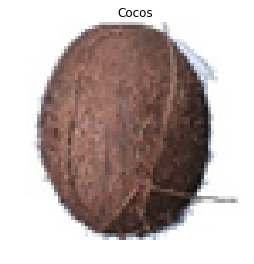

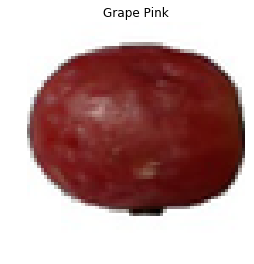

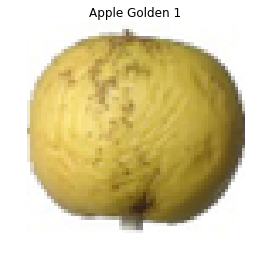

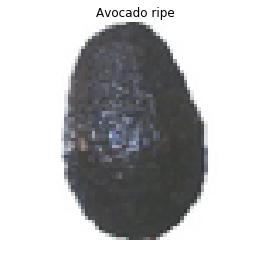

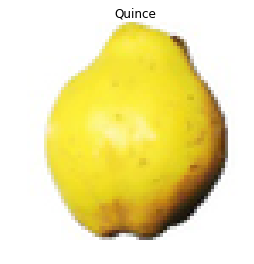

In [91]:
show_images(training.sample(5), 'label')

## Volumetría de los datos

### Training

In [21]:
training.shape

(31688, 12290)

In [22]:
training

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,B4088,B4089,B4090,B4091,B4092,B4093,B4094,B4095,label,path
0,255,255,255,255,255,255,254,251,253,254,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
2,251,255,255,255,252,249,251,254,255,253,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
3,255,250,251,255,255,254,253,254,255,245,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
4,253,250,253,255,255,253,253,255,255,251,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
5,255,252,248,249,254,255,255,253,251,250,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
6,254,254,254,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
7,255,255,252,251,254,255,255,254,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
8,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,Apple Braeburn,fruits-360_dataset_2018_05_26/fruits-360/Train...


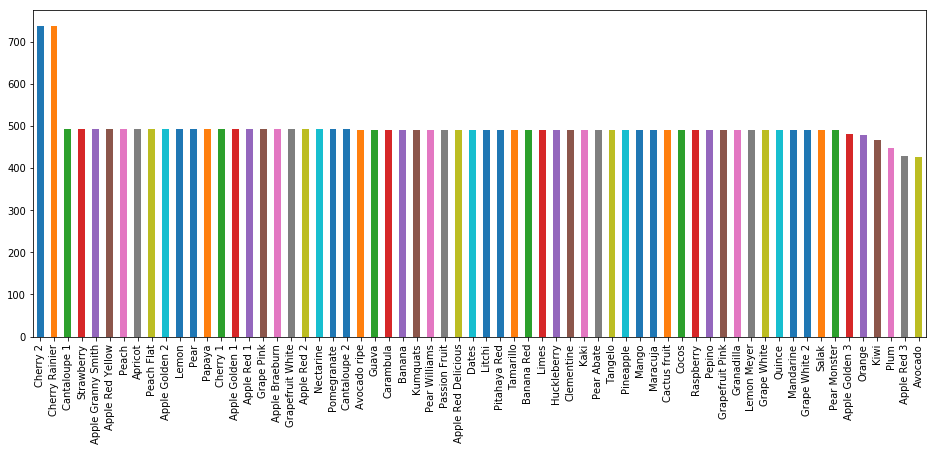

In [28]:
training.label.value_counts().plot.bar(figsize=(16,6));

### Test

In [24]:
test.shape

(5328, 12290)

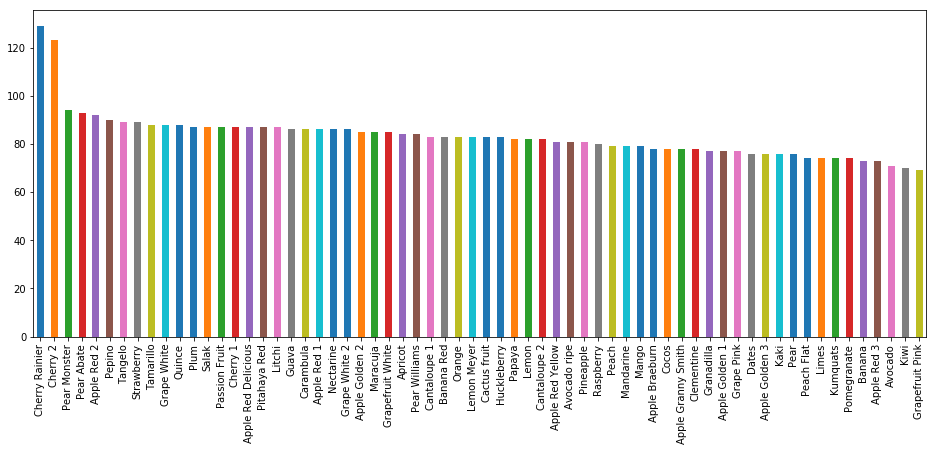

In [29]:
test.label.value_counts().plot.bar(figsize=(16,6));

### Validation

In [26]:
validation.shape

(5329, 12290)

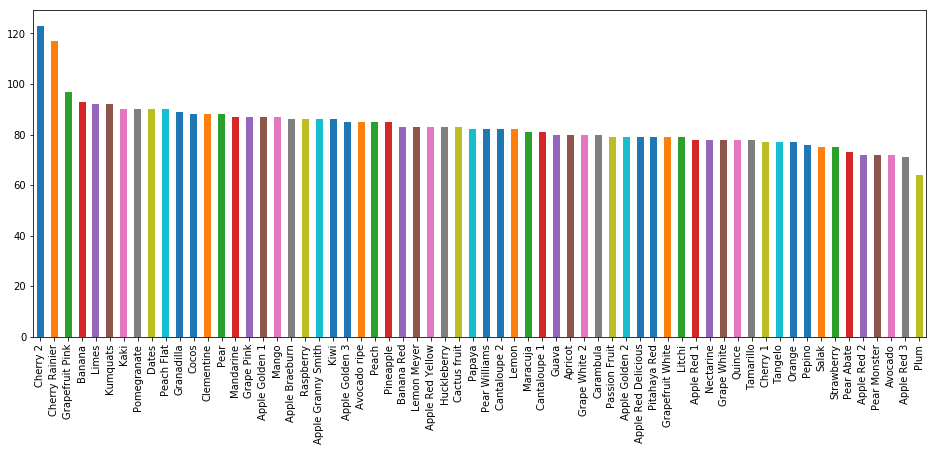

In [30]:
validation.label.value_counts().plot.bar(figsize=(16,6));